In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn import metrics
from sklearn.model_selection import train_test_split
import random
from google.colab import drive
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
!pip install hmmlearn

     |████████████████████████████████| 129 kB 8.3 MB/s 


In [ ]:
!pip install dtw

  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5315 sha256=c9d08d39cca5b1841d3a51ebcd5340a3dd1db24bdf1ddf164611170a0e6ba8e1
  Stored in directory: /root/.cache/pip/wheels/f9/51/54/b7f446e6d4f5be9a66066b59c5030731191260515737be4496
Successfully built dtw


In [ ]:
from dtw import dtw
import hmmlearn.hmm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# **1. Trích xuất các đặc trưng MFCCs**

In [ ]:
# Segment and label list of list
# element: [ Signal, label]
seg_lab = []

**Time to frame fomular**

$\begin{align} start_{frame} = \big\lfloor start_{time} \times samplingrate \big\rfloor \end{align}$

$\begin{align} end_{frame} = \big\lfloor end_{time} \times samplingrate \big\rfloor + 1 \end{align}$

In [ ]:
def mfcc_lab(path_without_ending, target_list):
    signal, sr = librosa.load(path_without_ending + '.wav')
    with open(path_without_ending + '.txt') as f:
            for line in f:
                if(line == ''): continue
                gr = ''.join(line).strip().split('\t')
                if len(gr) < 3: continue
                if gr[2] == 'sil': continue
                start_frame = int(float(gr[0]) * sr)
                end_frame = int(float(gr[1]) * sr) + 1
                lab = gr[2]
                # trích chọn đặc trưng trên thang mel với các thông số mặc định sampling rate = 22050, window hann, frame_size = 2048, hop_size = 512 (SFT matrix n_frame x window_length)
                # Dựa vào biến đổi Fast Fourier Transform trên từng frame
                mel_ftr = librosa.feature.melspectrogram(y=signal[start_frame:end_frame], sr=sr, window='hann')
                # trích chọn 13 đặc trưng MFCC từ Discrete Cosine Transform với các bộ lọc tam giác nối chân nhau từ spg: ma trận sau khi short time fourier transform trên segment.
                # đặc trưng thứ 13 là trung bình năng lượng của 12 đặc trưng
                mfccs = librosa.feature.mfcc(S = mel_ftr, n_mfcc=13, sr=sr)
                # trích chọn 13 đặc trưng tiếp theo chính là đạo hàm của 12 đặc trưng mfccs cộng thêm 1 đặc trưng là trung bình năng lượng của 12 đặc trưng đó
                delta_mfccs = librosa.feature.delta(mfccs)
                # tương tự nhưng là đạo hàm của 12 delta_mfccs và 1 trung bình năng lượng của tầng này
                delta2_mfccs = librosa.feature.delta(mfccs, order=2)
                mfccs_36 = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
                target_list.append([mfccs_36, lab])
    # print(path_without_ending)

In [ ]:
# read data without Silence label
def read_data_from_drive(data_fill):
    path99 = '/content/drive/My Drive/Ex1-2022/99/17021221_NguyenThanhDuy/'
    path14 = '/content/drive/My Drive/Ex1-2022/14/19021229_DangTrungCuong/'
    path7 = '/content/drive/My Drive/Ex1-2022/07/19021388_Kiều Văn Tuyên/'
    for i in range(1, 101):
        mfcc_lab(path99 + 'c' + str(i), data_fill)
        mfcc_lab(path14 + 'c' + str(i), data_fill)
        mfcc_lab(path7 + str(i), data_fill)

In [ ]:
read_data_from_drive(seg_lab)

In [ ]:
len(seg_lab)

3020

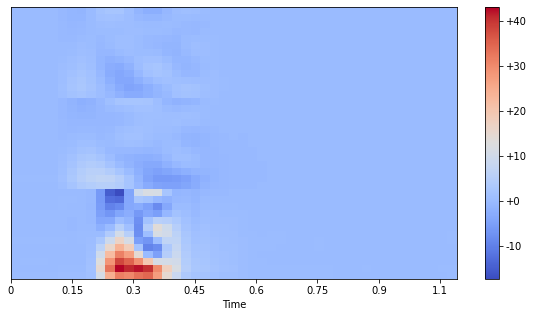

In [ ]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(seg_lab[21][0][:], 
                         x_axis="time", 
                         sr=22050)
plt.colorbar(format="%+2.f")
plt.show()

# **2. Phân loại từ đơn bằng Dynamic Time Wrapping**

In [ ]:
def prepare_datasets(dataset, N): 
    random.shuffle(dataset)

    x,y = [np.reshape(tst[x][0].T[:10].T , (-1)) for x in range(len(dataset))], [dataset[x][1] for x in range(len(dataset))]

    train_x = x[0:N]
    train_y = y[0:N]
    test_x =  x[N:len(dataset)]
    test_y =  y[N:len(dataset)]

    # Normalize / Standardize features
    scaler = StandardScaler()
    scaler.fit(train_x)
    train_x = [s.reshape(-1,39) for s in np.array(scaler.transform(train_x))]  
    test_x = [s.reshape(-1,39) for s in np.array(scaler.transform(test_x))]
        
    return train_x, train_y, test_x, test_y

In [ ]:
def alignment_validation(train_x, train_y, test_x, test_y): 
    predict = ['' for x in range(len(test_y))]

    for test_iter, test in enumerate(test_x):
        dist_min = math.inf
        for train_iter, train in enumerate(train_x):
            # Align bằng dtw với mục tiêu là chuẩn 2 norm (khoảng cách giữa 2 mẫu)
            dist, _, _, _ = dtw(test, train, dist=lambda test, train: np.linalg.norm(test - train, ord=1))
            if dist_min > dist: 
                dist_min = dist
                predict[test_iter] = train_y[train_iter]
    return predict

In [ ]:
tst = seg_lab.copy()

In [ ]:
train_x, train_y, test_x, test_y = prepare_datasets(tst, 2100)
# 1 / 3 bộ dữ liệu sẽ dùng cho train
predicted = alignment_validation(train_x, train_y, test_x, test_y) 
expected = test_y

In [ ]:
# Có data nào đó bị lỗi nhãn 'B' thành nhãn ' B'
[x for x in range(len(expected)) if expected[x] == ' B']

[613]

In [ ]:
# sửa lại output
expected[613] = 'B'
expected[613]

'B'

Classification report: 

              precision    recall  f1-score   support

           A       0.85      0.89      0.87       114
           B       0.78      0.83      0.80       111
         ban       0.88      0.80      0.84       107
         len       0.79      0.72      0.75       114
        nhay       0.91      0.87      0.89       123
        phai       0.73      0.81      0.77       101
        trai       0.82      0.83      0.83       114
       xuong       0.93      0.93      0.93       116

    accuracy                           0.84       900
   macro avg       0.84      0.84      0.84       900
weighted avg       0.84      0.84      0.84       900


Accuracy classification score: 83.67%
Precision classification score: 83.88%


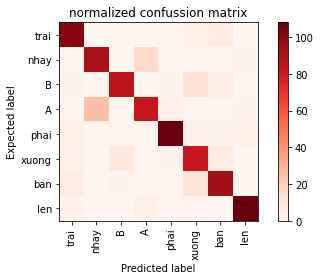

In [ ]:
print("Classification report: \n\n%s\n" % (metrics.classification_report(expected, predicted)))
mat = metrics.confusion_matrix(expected, predicted)
# len, xuong, trai, phai, A, B, ban
label_names = list(set(expected))
label_names = [x for x in label_names if x != ' B']
plt.figure()
plt.imshow(mat, interpolation='nearest', cmap='Reds')
plt.title('normalized confussion matrix')
plt.colorbar()
plt.ylabel('Expected label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, rotation=90)
plt.yticks(tick_marks, label_names)
plt.tight_layout()

# accuracy của từng từ đơn
accuracy = metrics.accuracy_score(expected, predicted)
print('Accuracy classification score: {0:.2f}%'.format(100*accuracy))
precision = metrics.precision_score(expected, predicted, average='weighted')
print('Precision classification score: {0:.2f}%'.format(100*precision))

# **3. Phân loại từ đơn bằng HMM (Hidden Markov Model)**

In [ ]:
# Phân cụm
def clustering(X, n_clusters=20):
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=42, verbose=0)
    kmeans.fit(X)
    print("centers", kmeans.cluster_centers_.shape)
    return kmeans

In [ ]:
# correct the data label
[x for x in range(len(seg_lab)) if seg_lab[x][1] == ' B']

[2793]

In [ ]:
seg_lab[2793][1] = 'B'

In [67]:
hmm_ds = seg_lab.copy()

In [70]:
class_names = ['len', 'xuong', 'trai', 'phai', 'A', 'B', 'ban']
data = {}
dataset = {}
for name in class_names:
    data[name] = [hmm_ds[x][0].T[:10].T for x in range(len(hmm_ds)) if hmm_ds[x][1] == name]
    data[f"test_{name}"] = data[name][-100:]
    data[name] = data[name][:-100]

In [74]:
len(data['len'])

283

In [90]:
# Gộp cụm
vt_ps = np.concatenate([np.concatenate(v, axis=1) for k, v in data.items() if k[:4]!='test'], axis=1).T

In [91]:
vt_ps.shape

(19060, 39)

In [92]:
# Tách cụm
kmeans = clustering(vt_ps)
vt_ps.shape, kmeans.cluster_centers_.shape

centers (20, 39)


((19060, 39), (20, 39))

In [93]:
components = {
    # len |l| ~ |e| ~ |n|
    "len": 9,
    # xuong |x|~|uo|~|ng|
    "xuong": 9,
    # phai |ph|~|a|~|i|
    "phai": 9,
    # trai |tr|~|a|~|i|
    "trai": 9,
    # A |a| ~
    "A": 3,
    # B |b|~
    "B": 3,
    # ban |b| ~ |a| ~ |n| 
    "ban": 9,
}

In [123]:
data[name][0].T.shape

(10, 39)

In [126]:
np.concatenate(data[name], axis = 1).T.shape

(2830, 39)

In [160]:
# HMM with gaussian mixture
models = {}
for name in class_names:
    class_vectors = data[name]
    km = kmeans
    dataset[name] = list([km.predict(v.T).reshape((-1,1)) for v in data[name]])
    dataset[f"test_{name}"] = list([km.predict(v.T).reshape((-1,1)) for v in data[f"test_{name}"]])

    if name[:4] != 'test':
        n = components[name]
        startprob = np.zeros(n)
        startprob[0] = 1.0
        transmat=np.diag(np.full(n,1))
        
        # Gaussian mixture
        hmm = hmmlearn.hmm.GMMHMM(
            n_components=n, 
            n_mix = 10, random_state=42, n_iter=100, verbose=True,
            params='st', init_params='st',
            startprob_prior=startprob,
            transmat_prior=transmat,
        )
    
        X = np.concatenate(data[name], axis=1).T
        # lengths = list([len(x) for x in data[name]])
        hmm.fit(X)
        models[name] = hmm

         1     -245290.4012             +nan
         2     -241992.5296       +3297.8715
         3     -241833.0921        +159.4375
         4     -241793.3472         +39.7449
         5     -241784.0761          +9.2711
         6     -241783.0715          +1.0046
         7     -241792.6480          -9.5765
         1     -213891.4496             +nan
         2     -209537.5872       +4353.8624
         3     -209494.2177         +43.3695
         4     -209496.9948          -2.7771
         1     -238332.2631             +nan
         2     -234244.3120       +4087.9510
         3     -234111.5832        +132.7289
         4     -234094.9041         +16.6791
         5     -234092.7842          +2.1199
         6     -234092.4281          +0.3561
         7     -234092.3890          +0.0391
         8     -234092.3885          +0.0005
         1     -198722.6878             +nan
         2     -195211.2014       +3511.4864
         3     -195122.9881         +88.2132
         4

In [161]:
np.concatenate(data[name], axis=1).T.shape

(2590, 39)

**Evaluation**

In [166]:
result = {}
for name in class_names:
    true_name = f"test_{name}"
    true_predict = 0
    for O in data[true_name]:
        score = {name : model.score(O.T, [O.shape[1]]) for name, model in models.items()}
        predict = max(score, key=score.get)
        if predict == name:
            true_predict += 1
    result[true_name] = f"Ratio: {true_predict}/{len(data[true_name])}\nAcc: {100*true_predict/len(data[true_name])}"

In [167]:
for k, v in result.items():
    print(k,'\n',v,'\n')

test_len 
 Ratio: 37/100
Acc: 37.0 

test_xuong 
 Ratio: 75/100
Acc: 75.0 

test_trai 
 Ratio: 29/100
Acc: 29.0 

test_phai 
 Ratio: 89/100
Acc: 89.0 

test_A 
 Ratio: 32/100
Acc: 32.0 

test_B 
 Ratio: 22/100
Acc: 22.0 

test_ban 
 Ratio: 21/100
Acc: 21.0 

